In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [2]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, latent_dim=20):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, 4, 2, 1),  # 28 → 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),           # 14 → 7
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=20, out_channels=1):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7 → 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, 4, 2, 1),  # 14 → 28
            nn.Sigmoid()
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), 64, 7, 7)
        return self.deconv(h)


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [4]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


In [5]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_recon, mu, logvar = model(x)
        loss = vae_loss(x_recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.2f}")


Epoch 1, Loss: 5786.70
Epoch 2, Loss: 4258.61
Epoch 3, Loss: 4077.40
Epoch 4, Loss: 4008.29
Epoch 5, Loss: 3958.73
Epoch 6, Loss: 3920.01
Epoch 7, Loss: 3884.61
Epoch 8, Loss: 3858.27
Epoch 9, Loss: 3832.41
Epoch 10, Loss: 3807.61


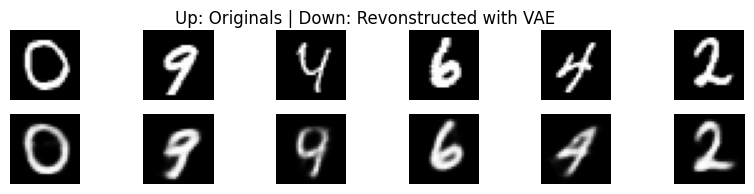

In [9]:
# Visualizza alcune ricostruzioni
x, _ = next(iter(train_loader))
x = x.to(device)
x_recon, _, _ = model(x)

plt.figure(figsize=(10, 2))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(x[i, 0].detach().cpu(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 6, i+7)
    plt.imshow(x_recon[i, 0].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.suptitle("Up: Originals | Down: Revonstructed with VAE")
plt.show()


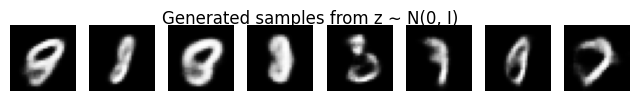

In [12]:
# Generazione immagini da z ~ N(0, I)
def generate_images(model, n=8, latent_dim=20):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        generated = model.decoder(z).cpu()
        
        plt.figure(figsize=(n, 1))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(generated[i, 0], cmap="gray")
            plt.axis("off")
        plt.suptitle("Generated samples from z ∼ N(0, I)")
        plt.show()

generate_images(model)


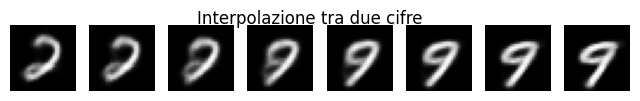

In [15]:
# Interpolazione lineare tra due immagini
def interpolate(model, x1, x2, steps=8):
    model.eval()
    with torch.no_grad():
        mu1, _ = model.encoder(x1.unsqueeze(0).to(device))
        mu2, _ = model.encoder(x2.unsqueeze(0).to(device))
        
        alphas = torch.linspace(0, 1, steps).unsqueeze(1).to(device)
        z_interp = mu1 * (1 - alphas) + mu2 * alphas
        recon = model.decoder(z_interp).cpu()
        
        plt.figure(figsize=(steps, 1))
        for i in range(steps):
            plt.subplot(1, steps, i+1)
            plt.imshow(recon[i, 0], cmap="gray")
            plt.axis("off")
        plt.suptitle("Interpolazione tra due cifre")
        plt.show()

# Esegui interpolazione su due cifre a caso
x_batch, y_batch = next(iter(train_loader))
x1 = x_batch[0]
x2 = x_batch[1]
interpolate(model, x1, x2)
